In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [45]:
train_dir = pathlib.Path('dogs_and_cats/train')
train_image_count = len(list(train_dir.glob('*/*.jpg')))
class_names = np.array([item.name for item in train_dir.glob('*')])
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

train_batches = image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 17500 images belonging to 2 classes.


In [3]:
test_dir = pathlib.Path('dogs_and_cats/test')
test_image_count = len(list(test_dir.glob('*/*.jpg')))
class_names = np.array([item.name for item in test_dir.glob('*')])
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(test_image_count/BATCH_SIZE)
test_batches = image_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 5000 images belonging to 2 classes.


In [4]:
val_dir = pathlib.Path('dogs_and_cats/validate')
val_image_count = len(list(val_dir.glob('*/*.jpg')))
class_names = np.array([item.name for item in val_dir.glob('*')])
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)
val_batches = image_generator.flow_from_directory(directory=str(val_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 2500 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

In [6]:
base_model.trainable = False

In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [8]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

  ...
    to  
  ['...']
20/20 [==============================] - 15s 763ms/step - loss: 0.8602 - accuracy: 0.4836
initial loss: 0.86
initial accuracy: 0.48


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=val_batches)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 547 steps, validate for 79 steps
Epoch 1/10
547/547 [==============================] - 142s 260ms/step - loss: 0.3948 - accuracy: 0.8073 - val_loss: 0.2438 - val_accuracy: 0.8954
Epoch 2/10
547/547 [==============================] - 61s 112ms/step - loss: 0.2155 - accuracy: 0.9119 - val_loss: 0.1894 - val_accuracy: 0.9212
Epoch 3/10
547/547 [==============================] - 59s 108ms/step - loss: 0.1790 - accuracy: 0.9264 - val_loss: 0.1740 - val_accuracy: 0.9304
Epoch 4/10
547/547 [==============================] - 60s 110ms/step - loss: 0.1621 - accuracy: 0.9339 - val_loss: 0.1582 - val_accuracy: 0.9376
Epoch 5/10
547/547 [==============================] - 59s 108ms/step - loss: 0.1520 - accuracy: 0.9365 - val_loss: 0.1421 - val_accuracy: 0.9462
Epoch 6/10
547/547 [==============================] - 60s 110ms/step - loss: 0.1450 - accuracy: 0.9393 - val_loss: 0.1397 - val_accuracy: 0.9470
Epoch 7/10
547/547 [================

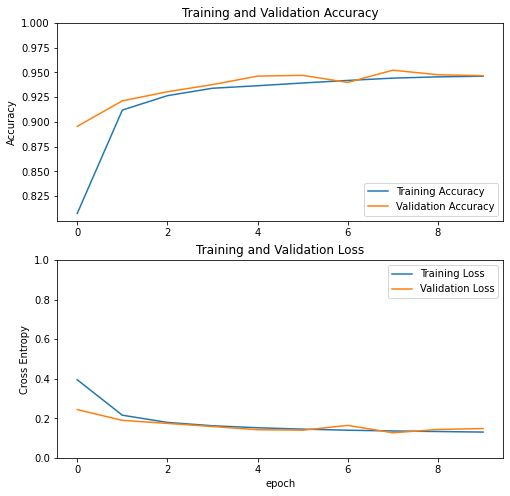

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [102]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
          metrics=['accuracy'])

In [104]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_batches)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 547 steps, validate for 79 steps
Epoch 10/20
547/547 [==============================] - 157s 287ms/step - loss: 0.1072 - accuracy: 0.9569 - val_loss: 0.0918 - val_accuracy: 0.9674
Epoch 11/20
547/547 [==============================] - 85s 155ms/step - loss: 0.0631 - accuracy: 0.9767 - val_loss: 0.0874 - val_accuracy: 0.9682
Epoch 12/20
547/547 [==============================] - 80s 146ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.0807 - val_accuracy: 0.9718
Epoch 13/20
547/547 [==============================] - 81s 147ms/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 0.0843 - val_accuracy: 0.9724
Epoch 14/20
547/547 [==============================] - 81s 148ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 0.0904 - val_accuracy: 0.9730
Epoch 15/20
547/547 [==============================] - 80s 147ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.0883 - val_accuracy: 0.9754
Epoch 16/20
547/547 [=========

In [105]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

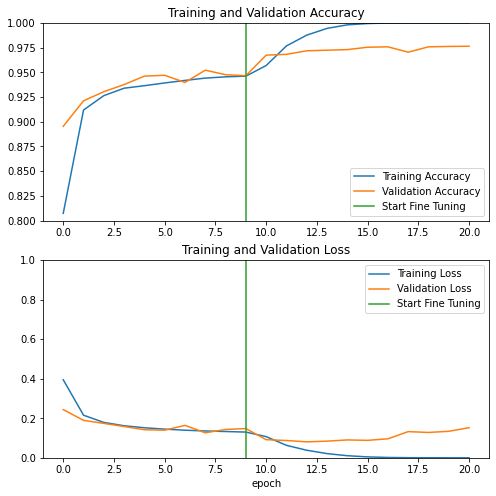

In [118]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
predictions = tf.nn.softmax(model.predict(test_batches)).numpy()

In [108]:
test_labels = []
test_images = []
for i in tqdm(range(len(test_batches))):
    images, labels = test_batches[i]
    test_images.extend(images)
    test_labels.extend(labels)
test_images = np.array(test_images)
test_labels = np.array([np.argmax(l) for l in test_labels])

In [128]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([0,0.5, 1])
    thisplot = plt.bar(range(2), predictions_array, color="#777777", width=0.5, tick_label=class_names)
    plt.ylim([0, 1])
    plt.xlim([-0.5, 1.5])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

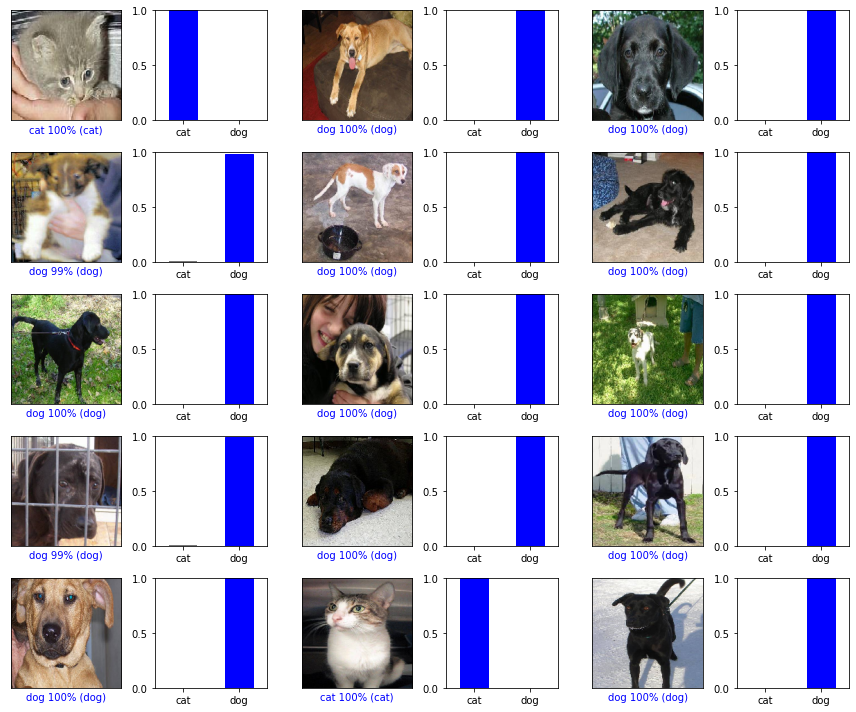

In [129]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(0, num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [117]:
model.evaluate(test_batches)

  ...
    to  
  ['...']
157/157 [==============================] - 14s 89ms/step - loss: 0.1514 - accuracy: 0.9738


[0.15143371986458856, 0.9738]